In [ ]:
import json
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from architectures import *
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from utils import *

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 37

ROOT_PATH = os.getcwd()
os.makedirs(LOGS_PATH := os.path.join(ROOT_PATH, "logs"), exist_ok=True)
os.makedirs(RAW_DATASET_PATH := os.path.join(ROOT_PATH, "dataset", "raw"), exist_ok=True)
os.makedirs(PRODUCTION_DATASET_PATH := os.path.join(ROOT_PATH, "dataset", "production"), exist_ok=True)
os.makedirs(MODELS_PATH := os.path.join(ROOT_PATH, "models"), exist_ok=True)

print(DEVICE)
seed_functions(SEED)

cuda


Preprocessing

In [2]:
SUBSAMPLE_SIZE = 10000
NOISE_RATIO = 0.5
EARTHQUAKE_RATIO = 0.5

def preprocess_data():
	"""Computes, saves, and prints summary of preprocessed data."""

	# Compute preprocessed data
	data_processor = DataPreprocessing(
		subsample_size=SUBSAMPLE_SIZE,
		raw_dataset_path=RAW_DATASET_PATH,
		logs_path=LOGS_PATH,
		noise_ratio=NOISE_RATIO,
		earthquake_ratio=EARTHQUAKE_RATIO
	)

	# Save preprocessed data
	signals = data_processor.subsample_traces
	np.save(os.path.join(PRODUCTION_DATASET_PATH, f"signals_{SUBSAMPLE_SIZE}.npy"), np.array(list(signals.values())))
	metadata = data_processor.subsample_metadata
	metadata.to_feather(os.path.join(PRODUCTION_DATASET_PATH, f"metadata_{SUBSAMPLE_SIZE}.feather"))
	waveform_images = data_processor.create_waveform_images()
	np.save(os.path.join(PRODUCTION_DATASET_PATH, f"waveform_images_{SUBSAMPLE_SIZE}.npy"), waveform_images)
	spectrogram_images = data_processor.create_spectrogram_images()
	np.save(os.path.join(PRODUCTION_DATASET_PATH, f"spectrogram_images_{SUBSAMPLE_SIZE}.npy"), spectrogram_images)

	# Print summary of preprocessed data
	print(f"""
	1. Expected samples: {SUBSAMPLE_SIZE}
	2. Actual samples: {len(signals)}\n{metadata['category'].value_counts(normalize=True)}
	""")

# preprocess_data()

def visualise_data(num_samples=1):
	"""Randomly selects and plots pair(s) of waveform and spectrogram images."""

	# Load saved images
	waveform_images = np.load(os.path.join(PRODUCTION_DATASET_PATH, f"waveform_images_{SUBSAMPLE_SIZE}.npy"))
	spectrogram_images = np.load(os.path.join(PRODUCTION_DATASET_PATH, f"spectrogram_images_{SUBSAMPLE_SIZE}.npy"))

	# Create figure with subplots
	fig, axes = plt.subplots(num_samples, 2, figsize=(6, 3 * num_samples))

	# Ensure axes is iterable for a single sample case
	if num_samples == 1:
		axes = [axes]

	# Plot random images
	for i1, i2 in enumerate(np.random.choice(len(waveform_images), num_samples, replace=False)):
		axes[i1][0].imshow(waveform_images[i2])
		axes[i1][0].set_title(f"Waveform {i2}")
		axes[i1][0].axis("off")
		axes[i1][1].imshow(spectrogram_images[i2])
		axes[i1][1].set_title(f"Spectrogram {i2}")
		axes[i1][1].axis("off")
	plt.tight_layout()
	plt.show()

# visualise_data()

Training

In [3]:
BATCH_SIZE = 32
LEARNING_RATE = 0.001
NUM_EPOCHS = 50
PATIENCE = 7

# Load production dataset and compute labels
spectrograms = np.load(os.path.join(PRODUCTION_DATASET_PATH, f"spectrogram_images_{SUBSAMPLE_SIZE}.npy"))
metadata = pd.read_feather(os.path.join(PRODUCTION_DATASET_PATH, f"metadata_{SUBSAMPLE_SIZE}.feather"))
labels = (metadata["category"] == "earthquake").astype(np.float32).values  # 0 (noise), 1 (earthquake)

# Normalize and convert spectrograms and labels to tensors
spectrograms = torch.tensor(spectrograms.astype(np.float32) / 255.0).permute(0, 3, 1, 2)
labels = torch.tensor(labels).view(-1, 1)

def split_data(spectrograms, labels, test_size=0.2, dev_size=0.5):
	train_i, temp_i, train_labels, temp_labels = train_test_split(spectrograms, labels, test_size=test_size, stratify=labels, random_state=SEED)
	dev_i, test_i, dev_labels, test_labels = train_test_split(temp_i, temp_labels, test_size=dev_size, stratify=temp_labels, random_state=SEED)
	return train_i, train_labels, dev_i, dev_labels, test_i, test_labels

# Split production dataset into train, dev, and test sets
train_i, train_labels, dev_i, dev_labels, test_i, test_labels = split_data(spectrograms, labels)

In [ ]:
def load_data(model):
	train_generator = torch.Generator()
	train_generator.manual_seed(SEED)

	if getattr(model, "expects224", False):
		train_loader = DataLoader(SpectrogramDataset224(SpectrogramDataset(train_i, train_labels)), batch_size=BATCH_SIZE, shuffle=True, generator=train_generator)
		dev_loader = DataLoader(SpectrogramDataset224(SpectrogramDataset(dev_i, dev_labels)), batch_size=BATCH_SIZE, shuffle=False)
		test_loader = DataLoader(SpectrogramDataset224(SpectrogramDataset(test_i, test_labels)), batch_size=BATCH_SIZE, shuffle=False)
		return train_loader, dev_loader, test_loader

	train_loader = DataLoader(SpectrogramDataset(train_i, train_labels), batch_size=BATCH_SIZE, shuffle=True, generator=train_generator)
	dev_loader = DataLoader(SpectrogramDataset(dev_i, dev_labels), batch_size=BATCH_SIZE, shuffle=False)
	test_loader = DataLoader(SpectrogramDataset(test_i, test_labels), batch_size=BATCH_SIZE, shuffle=False)
	return train_loader, dev_loader, test_loader

model = ViTB16().to(DEVICE)
train_loader, dev_loader, test_loader = load_data(model)

In [5]:
def train_model(model, train_loader, dev_loader, criterion, optimizer):
	# Create model folder
	model_folder = os.path.join(MODELS_PATH, f"{model.id}")
	os.makedirs(model_folder, exist_ok=True)

	best_dev_loss = float("inf")
	best_model_path = os.path.join(model_folder, "best.pth")
	patience_counter = 0
	train_losses = []
	dev_losses = []

	for epoch in range(NUM_EPOCHS):
		# Train model on train set
		model.train()
		total_loss = 0
		for images, labels in train_loader:
			images, labels = images.to(DEVICE), labels.to(DEVICE)
			optimizer.zero_grad()
			outputs = model(images)
			loss = criterion(outputs, labels)
			loss.backward()
			optimizer.step()
			total_loss += loss.item()
		train_loss = total_loss / len(train_loader)
		train_losses.append(train_loss)

		# Evaluate model on dev set
		model.eval()
		dev_loss = 0
		with torch.no_grad():
			for images, labels in dev_loader:
				images, labels = images.to(DEVICE), labels.to(DEVICE)
				outputs = model(images)
				dev_loss += criterion(outputs, labels).item()
		dev_loss /= len(dev_loader)
		dev_losses.append(dev_loss)

		print(f"Epoch {epoch+1}/{NUM_EPOCHS} - Train Loss: {train_loss:.4f} - Dev Loss: {dev_loss:.4f}")

		# Save model epoch checkpoint
		torch.save(model.state_dict(), os.path.join(model_folder, f"epoch={epoch+1}-dev_loss={dev_loss:.4f}.pth"))

		if dev_loss < best_dev_loss:
			best_dev_loss = dev_loss
			torch.save(model.state_dict(), best_model_path)  # Save best model
			patience_counter = 0  # Reset patience counter
		else:
			patience_counter += 1
			# Stop early if needed
			if patience_counter >= PATIENCE:
				print("Stopping early")
				break

	# Save losses
	loss_data = {"train_losses": train_losses, "dev_losses": dev_losses}
	with open(os.path.join(model_folder, "losses.json"), "w") as f:
		json.dump(loss_data, f)

criterion = nn.BCELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

# train_model(model, train_loader, dev_loader, criterion, optimizer)

Post-training

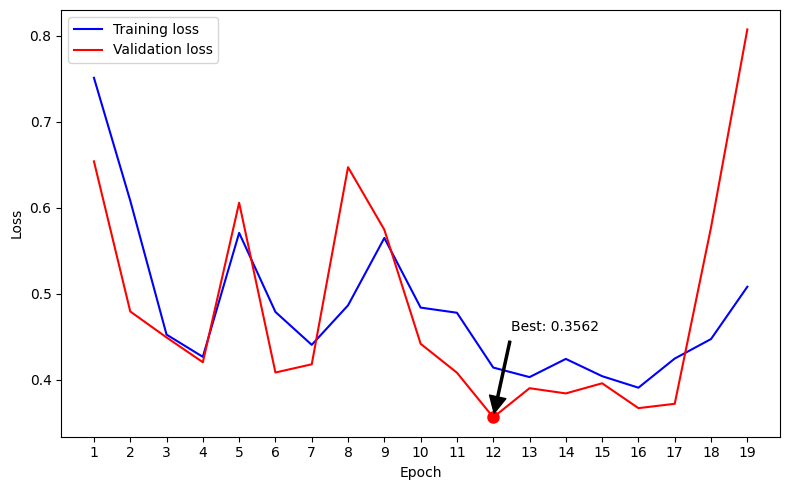

{'tp': np.int64(393), 'tn': np.int64(424), 'fp': np.int64(76), 'fn': np.int64(107), 'f1': np.float64(0.8111455108359134)}


In [ ]:
def visualise_training(model):
	model_folder = os.path.join(MODELS_PATH, f"{model.id}")
	with open(os.path.join(model_folder, "losses.json"), "r") as f:
		loss_data = json.load(f)
	train_losses = loss_data["train_losses"]
	dev_losses = loss_data["dev_losses"]
	plt.figure(figsize=(8, 5))
	epochs = range(1, len(train_losses) + 1)
	plt.plot(epochs, train_losses, "b-", label="Training loss")
	plt.plot(epochs, dev_losses, "r-", label="Validation loss")
	plt.xlabel("Epoch")
	plt.ylabel("Loss")
	plt.legend()
	best_epoch = np.argmin(dev_losses) + 1
	best_loss = min(dev_losses)
	plt.plot(best_epoch, best_loss, "ro", markersize=8)
	plt.annotate(
		f"Best: {best_loss:.4f}",
		xy=(best_epoch, best_loss),
		xytext=(best_epoch + 0.5, best_loss + 0.1),
		arrowprops=dict(facecolor="black", shrink=0.05, width=1.5)
	)
	plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))
	plt.tight_layout()
	plt.show()

def evaluate_model(model, test_loader):
	model.eval()
	Y_hat, Y = [], []

	with torch.no_grad():
		for x, y in test_loader:
			Y_hat.append(model(x.to(DEVICE)).round().cpu())
			Y.append(y)

	tn, fp, fn, tp = confusion_matrix(torch.cat(Y), torch.cat(Y_hat)).ravel()
	print({"tp": tp, "tn": tn, "fp": fp, "fn": fn, "f1": compute_f1(tp, tn, fp, fn)})

m = ViTB16().to(DEVICE)
visualise_training(m)

m.load_state_dict(torch.load(os.path.join(MODELS_PATH, m.id, "best.pth")))
evaluate_model(m, test_loader)